# Research Project 



#### Finding data
- BTC price from API? or from different sources
- Oil, Gold, S&P 500 from Yahoo/Crsp/FactSet?
- Google trend - we can find google trend also through api --> pytrends: https://pypi.org/project/pytrends/
- Inflation, Interest rate in the US - CRSP or some other webpage with reliable info
+ Deciding whether we will use returns/ prices/ so on :)

In [1]:
#pip install pandas-datareader

In [2]:
import pandas_datareader.data as web
import pandas as pd
import datetime as dt
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.preprocessing import StandardScaler

### Factor 1, 2 + 3
Gold, Oil, S&P500

In [57]:
#Import yahoo finance data: Gold, SP500, Oil
yahoofin_prices = web.DataReader(['GC=F', 'CL=F', '^GSPC'], 'yahoo', start='2019-12-31', end='2022-01-18')["Adj Close"]
yahoofin_prices.rename(columns={'GC=F': 'GOLD', 'CL=F': 'OIL', '^GSPC': 'SP500'}, inplace=True)

In [59]:
#Print Gold, Oil, SP500 prices
yahoofin_prices.head()

Symbols,GOLD,OIL,SP500
Date,,,
2019-12-31,1519.500000,61.060001,3230.780029
2020-01-02,1524.500000,61.180000,3257.850098
2020-01-03,1549.199951,63.049999,3234.850098
2020-01-06,1566.199951,63.270000,3246.280029
2020-01-07,1571.800049,62.700001,3237.179932


In [60]:
#Info of Gold, Oil, SP500 prices
yahoofin_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518 entries, 2019-12-31 to 2022-01-18
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOLD    518 non-null    float64
 1   OIL     518 non-null    float64
 2   SP500   517 non-null    float64
dtypes: float64(3)
memory usage: 16.2 KB


In [61]:
#Calculate the returns of the prices
yahoofin_returns = yahoofin_prices.copy()
for i in range(1,len(yahoofin_prices+1)):
    yahoofin_returns.iloc[i] = np.log(yahoofin_prices.iloc[i]/yahoofin_prices.iloc[i-1])
yahoofin_returns = yahoofin_returns[1:]

/Users/carlarunden/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [62]:
#Print Gold, Oil, SP500 returns
yahoofin_returns.head()

Symbols,GOLD,OIL,SP500
Date,,,
2020-01-02,0.003285,0.001963,0.008344
2020-01-03,0.016072,0.030108,-0.007085
2020-01-06,0.010914,0.003483,0.003527
2020-01-07,0.003569,-0.009050,-0.002807
2020-01-08,-0.009204,-0.050538,0.004890


### Factor 4
Effective Federal Funds Rate

In [63]:
#Import Effective federal funds rate (https://fred.stlouisfed.org/series/EFFR) 
interestrate = web.DataReader(['EFFR'], 'fred', start='2020-01-01', end='2022-01-01')
interestrate.rename(columns={'EFFR': 'IR'}, inplace=True)
interestrate['IR']= df2['IR']/100

In [64]:
#Merge first 4 factors
yahoofin_IR = yahoofin_prices.merge(interestrate, how= 'left', left_index = True, right_index = True)

In [65]:
#Print head
yahoofin_IR.head()

,GOLD,OIL,SP500,IR
Date,,,,
2019-12-31,1519.500000,61.060001,3230.780029,NaN
2020-01-02,1524.500000,61.180000,3257.850098,0.000155
2020-01-03,1549.199951,63.049999,3234.850098,0.000155
2020-01-06,1566.199951,63.270000,3246.280029,0.000155
2020-01-07,1571.800049,62.700001,3237.179932,0.000155


In [9]:
# df3 = web.DataReader(['CPIAUCSL'], 'fred', start='2019-11-30', end='2022-01-01')
# df3.rename(columns={'CPIAUCSL': 'INFL'}, inplace=True)

In [10]:
# infl = df3.copy()
# for i in range(1,len(df3+1)):
#     infl.iloc[i] = np.log(df3.iloc[i]/df3.iloc[i-1])
# infl = infl[1:]
# infl.head()

------------------------------------------------------------------------------------------------------------------

#### Other possible factors

### Factor 5 + 6
US daily News Index + Bitcoin Transactions

In [66]:
# US Daily News Index (http://www.policyuncertainty.com/us_monthly.html)
daily_news = pd.read_csv('data/All_Daily_Policy_Data.csv')
daily_news['date'] = pd.to_datetime(dict(year=daily_news.year, month=daily_news.month, day=daily_news.day))
daily_news.set_index('date', inplace = True)
daily_news = pd.DataFrame(daily_news.daily_policy_index)
daily_news = daily_news.loc['2019-12-31':]
daily_news.rename(columns = {'daily_policy_index': 'EPU'}, inplace=True)

In [67]:
# The number of daily confirmed Bitcoin transactions (https://data.nasdaq.com/data/BCHAIN/NTRAN-bitcoin-number-of-transactions)
transactions = pd.read_csv('data/BCHAIN-NTRAN.csv')
transactions.sort_values(by=['Date'], ascending=True, inplace=True)
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions.set_index('Date', inplace = True)
transactions = transactions.loc['2019-12-31':]
transactions.rename(columns = {'Value': 'transactions'}, inplace=True)

In [68]:
#Merge the daily Index and the Bitcoin transactions
dailynews_transactions = daily_news.merge(transactions, left_index = True, right_index = True)

In [69]:
#Print the head
dailynews_transactions.head()

,EPU,transactions
date,,
2019-12-31,105.75,293447.0
2020-01-01,186.06,251735.0
2020-01-02,139.13,295567.0
2020-01-03,108.10,316517.0
2020-01-04,212.82,287215.0


### Factor 7
VIX index

In [71]:
#The VIX Index is recognized as the world’s premier gauge of U.S. equity market volatility
# (https://www.cboe.com/tradable_products/vix/)
VIX = pd.read_csv('data/VIX_History.csv')
VIX['DATE'] = pd.to_datetime(VIX['DATE'])
VIX.set_index('DATE', inplace = True)
VIX = VIX.loc['2019-12-31':]
VIX.rename(columns = {'CLOSE': 'VIX'}, inplace=True)
VIX = pd.DataFrame(VIX.VIX)

In [72]:
#Merge the daily Index, the Bitcoin transactions and VIX
dn_trans_VIX = dailynews_transactions.merge(VIX, left_index = True, right_index = True)

In [73]:
#Print head
dn_trans_VIX.head()

,EPU,transactions,VIX
2019-12-31,105.75,293447.0,13.78
2020-01-02,139.13,295567.0,12.47
2020-01-03,108.10,316517.0,14.02
2020-01-06,147.96,299146.0,13.85
2020-01-07,103.98,344079.0,13.79


In [74]:
#Turn into Returns
dn_trans_VIX_returns = dn_trans_VIX.copy()
for i in range(1,len(dn_trans_VIX+1)):
    dn_trans_VIX_returns.iloc[i] = np.log(dn_trans_VIX.iloc[i]/dn_trans_VIX.iloc[i-1])
dn_trans_VIX_returns = dn_trans_VIX_returns[1:]

In [75]:
#Print return
dn_trans_VIX_returns.head()

,EPU,transactions,VIX
2020-01-02,0.274331,0.007199,-0.099893
2020-01-03,-0.252352,0.068481,0.117159
2020-01-06,0.313885,-0.056445,-0.012200
2020-01-07,-0.352743,0.139940,-0.004342
2020-01-08,-0.131692,-0.078760,-0.024965


### Factor 8 + 9
D_infections_volatility_tracker + DOW JONES GLOBAL_DJUSCA

In [76]:
#Import D_infections_volatility_tracker
path = os.path.join('data','D_infections_volatility_tracker.xlsx')
df_InfVol = pd.read_excel(path)
df_EMV= df_InfVol.drop(columns=['day', 'month', 'year'])
df_emv= df_EMV.set_index('date')

In [78]:
df_emv.head()

,daily_infect_emv_index
date,
2020-01-01,1.89
2020-01-02,2.84
2020-01-03,1.33
2020-01-04,0.00
2020-01-05,0.86


In [77]:
#Import DOW JONES GLOBAL_DJUSCA
path = os.path.join('data','DOW JONES GLOBAL_DJUSCA.csv')
df_DOWJ = pd.read_csv(path)
df_DOWJG= df_DOWJ[["Close", "Date"]]
df_DOWJG.rename(columns = {'Close': 'DOWJ'}, inplace=True)
df_DOWJG['Date'] = pd.to_datetime(df_DOWJG['Date'])
df_DOW=df_DOWJG.set_index('Date')
df_DOW.sort_values(by= 'Date', axis=0, ascending=True, inplace=True)
df_dow = pd.to_numeric(df_DOW['DOWJ'], errors='coerce')

/Users/carlarunden/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-77-9316d9ac326a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DOWJG['Date'] = pd.to_datetime(df_DOWJG['Date'])


In [79]:
df_dow.head()

Date
2020-01-02    935.13
2020-01-03    923.15
2020-01-06    922.07
2020-01-07    923.21
2020-01-08    931.08
Name: DOWJ, dtype: float64

In [80]:
df303 = dn_trans_VIX.merge(df_dow, left_index = True, right_index = True)
df404 = df303.merge(df_emv, left_index = True, right_index = True)

In [81]:
df404.head()

,EPU,transactions,VIX,DOWJ,daily_infect_emv_index
2020-01-02,139.13,295567.0,12.47,935.13,2.84
2020-01-03,108.10,316517.0,14.02,923.15,1.33
2020-01-06,147.96,299146.0,13.85,922.07,0.99
2020-01-07,103.98,344079.0,13.79,923.21,0.00
2020-01-08,91.15,318019.0,13.45,931.08,0.56


In [20]:
#Transform into returns
df_merge_returns = df303.copy()
for i in range(1,len(df303+1)):
    df_merge_returns.iloc[i] = np.log(df303.iloc[i]/df303.iloc[i-1])
df_merge_returns = df_merge_returns[1:]

In [21]:
df_all= df_merge_returns.merge(df_emv, left_index=True, right_index=True)

<AxesSubplot:>

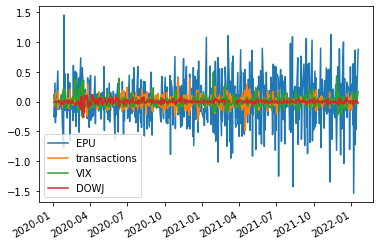

In [22]:
df_merge_returns.plot()

I think for the daily infectious diseasse tracker, we cant take log --> it will divide somethin with 0 and the result will be nan/-inf. So for that i thik its better to standardize, but for all others i think it is fine.

### Factor 10-13
Exchange rates

In [101]:
#Import Exchange rate Romania
romania = os.path.join('data','USD_RON_.csv')
df_romania = pd.read_csv(romania)
df_romania['Date'] = pd.to_datetime(df_romania['Date'])
df_romania=df_romania.set_index('Date')

#Delete the percentage sign
df_romania['Change %'] = list(map(lambda x: x[:-1], df_romania['Change %'].values))

#Rename
df_romania.rename(columns = {'Change %': 'USD_RON Change %'}, inplace=True)

In [103]:
df_romania.head()

,USD_RON Change %
Date,
2022-01-20,-0.13
2022-01-19,-0.14
2022-01-18,0.73
2022-01-17,0.07
2022-01-14,0.35


In [105]:
#Import Exchange rate India
india = os.path.join('data','USD_INR.csv')
df_india = pd.read_csv(india)
df_india['Date'] = pd.to_datetime(df_india['Date'])
df_india=df_india.set_index('Date')

#Delete the percentage sign
df_india['Change %'] = list(map(lambda x: x[:-1], df_india['Change %'].values))

#Rename
df_india.rename(columns = {'Change %': 'USD_INR Change %'}, inplace=True)

In [106]:
df_india.head()

,USD_INR Change %
Date,
2022-01-20,-0.07
2022-01-19,-0.18
2022-01-18,0.43
2022-01-17,0.12
2022-01-14,0.26


In [107]:
#Import Exchange rate kazakhstan
kazakhstan = os.path.join('data','USD_KZT_.csv')
df_kazakhstan = pd.read_csv(kazakhstan)
df_kazakhstan['Date'] = pd.to_datetime(df_kazakhstan['Date'])
df_kazakhstan=df_kazakhstan.set_index('Date')

#Delete the percentage sign
df_kazakhstan['Change %'] = list(map(lambda x: x[:-1], df_kazakhstan['Change %'].values))

#Rename
df_kazakhstan.rename(columns = {'Change %': 'USD_KZT Change %'}, inplace=True)

In [108]:
#Print head
df_kazakhstan.head()

,USD_KZT Change %
Date,
2022-01-20,-0.14
2022-01-19,0.16
2022-01-18,0.09
2022-01-17,0.03
2022-01-14,0.10


------------------------------------------------------------------------------------------------------------------

In [23]:
#pip install pytrends

In [24]:
from pytrends.request import TrendReq
from pytrends import dailydata

Bitcoin_df = dailydata.get_daily_data('Bitcoin', 2020, 1, 2022, 1, geo = 'US')

Bitcoin:2020-01-01 2020-01-31
Bitcoin:2020-02-01 2020-02-29
Bitcoin:2020-03-01 2020-03-31
Bitcoin:2020-04-01 2020-04-30
Bitcoin:2020-05-01 2020-05-31
Bitcoin:2020-06-01 2020-06-30
Bitcoin:2020-07-01 2020-07-31
Bitcoin:2020-08-01 2020-08-31
Bitcoin:2020-09-01 2020-09-30
Bitcoin:2020-10-01 2020-10-31
Bitcoin:2020-11-01 2020-11-30
Bitcoin:2020-12-01 2020-12-31
Bitcoin:2021-01-01 2021-01-31
Bitcoin:2021-02-01 2021-02-28
Bitcoin:2021-03-01 2021-03-31
Bitcoin:2021-04-01 2021-04-30
Bitcoin:2021-05-01 2021-05-31
Bitcoin:2021-06-01 2021-06-30
Bitcoin:2021-07-01 2021-07-31
Bitcoin:2021-08-01 2021-08-31
Bitcoin:2021-09-01 2021-09-30
Bitcoin:2021-10-01 2021-10-31
Bitcoin:2021-11-01 2021-11-30
Bitcoin:2021-12-01 2021-12-31
Bitcoin:2022-01-01 2022-01-31


In [25]:
Bitcoin_df

,Bitcoin_unscaled,Bitcoin_monthly,isPartial,scale,Bitcoin
date,,,,,
2020-01-01,47,NaN,NaN,NaN,NaN
2020-01-02,60,NaN,NaN,NaN,NaN
2020-01-03,68,NaN,NaN,NaN,NaN
2020-01-04,83,NaN,NaN,NaN,NaN
2020-01-05,67,14.0,False,0.14,9.38
...,...,...,...,...,...
2022-01-14,69,33.0,NaN,0.33,22.77
2022-01-15,56,33.0,NaN,0.33,18.48
2022-01-16,55,28.0,True,0.28,15.40


------------------------------------------------------------------------------------------------------------------

### Standardising Bitcoin data (changed from unscaled to Bitcoin)

In [26]:
df_x = Bitcoin_df[["Bitcoin"]]

In [27]:
df_x.dropna(inplace=True)

<ipython-input-27-99f8a002d145>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.dropna(inplace=True)


In [28]:
df_x

,Bitcoin
date,
2020-01-05,9.38
2020-01-06,9.10
2020-01-07,12.46
2020-01-08,13.44
2020-01-09,9.24
...,...
2022-01-14,22.77
2022-01-15,18.48
2022-01-16,15.40


In [29]:
# create a scaler object
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
df_data_st = pd.DataFrame(std_scaler.fit_transform(df_x), columns=df_x.columns)

df_data_st

,Bitcoin
0,-0.748070
1,-0.766534
2,-0.544962
3,-0.480337
4,-0.757302
...,...
740,0.134922
741,-0.147979
742,-0.351086
743,-0.184907


In [30]:
df_data_st.index=df_x.index

------------------------------------------------------------------------------------------------------------------

In [31]:
path = os.path.join('data','BTC-USD-2.csv')
df_data = pd.read_csv(path)
df_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df_data['Date']=pd.to_datetime(df_data['Date'])

In [32]:
df_btc=df_data.set_index('Date')

In [33]:
returns_btc = df_btc.copy()
for i in range(1,len(df_btc+1)):
    returns_btc.iloc[i] = np.log(df_btc.iloc[i]/df_btc.iloc[i-1])
returns_btc = returns_btc[1:]

In [34]:
returns_btc

,Close
Date,
2020-01-02,-0.030273
2020-01-03,0.050172
2020-01-04,0.008915
2020-01-05,0.000089
2020-01-06,0.047161
...,...
2022-01-11,0.021633
2022-01-12,0.027994
2022-01-13,-0.031376


In [35]:
btc_merged=returns_btc.join(df_data_st)
btc_df= btc_merged.merge(df, left_index=True, right_index=True)
btc_data= btc_df.merge(df_merge_returns, left_index=True, right_index=True)

In [36]:
data_btc=btc_data.dropna()

In [37]:
data_btc.rename(columns={"Bitcoin": "GoogleTrend", "Close": "BTC_ret"}, inplace=True)

/Users/carlarunden/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Descriptives - get to know the data

array([[<AxesSubplot:title={'center':'BTC_ret'}>,
        <AxesSubplot:title={'center':'GoogleTrend'}>,
        <AxesSubplot:title={'center':'GOLD'}>],
       [<AxesSubplot:title={'center':'OIL'}>,
        <AxesSubplot:title={'center':'SP500'}>,
        <AxesSubplot:title={'center':'IR'}>],
       [<AxesSubplot:title={'center':'EPU'}>,
        <AxesSubplot:title={'center':'transactions'}>,
        <AxesSubplot:title={'center':'VIX'}>],
       [<AxesSubplot:title={'center':'DOWJ'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

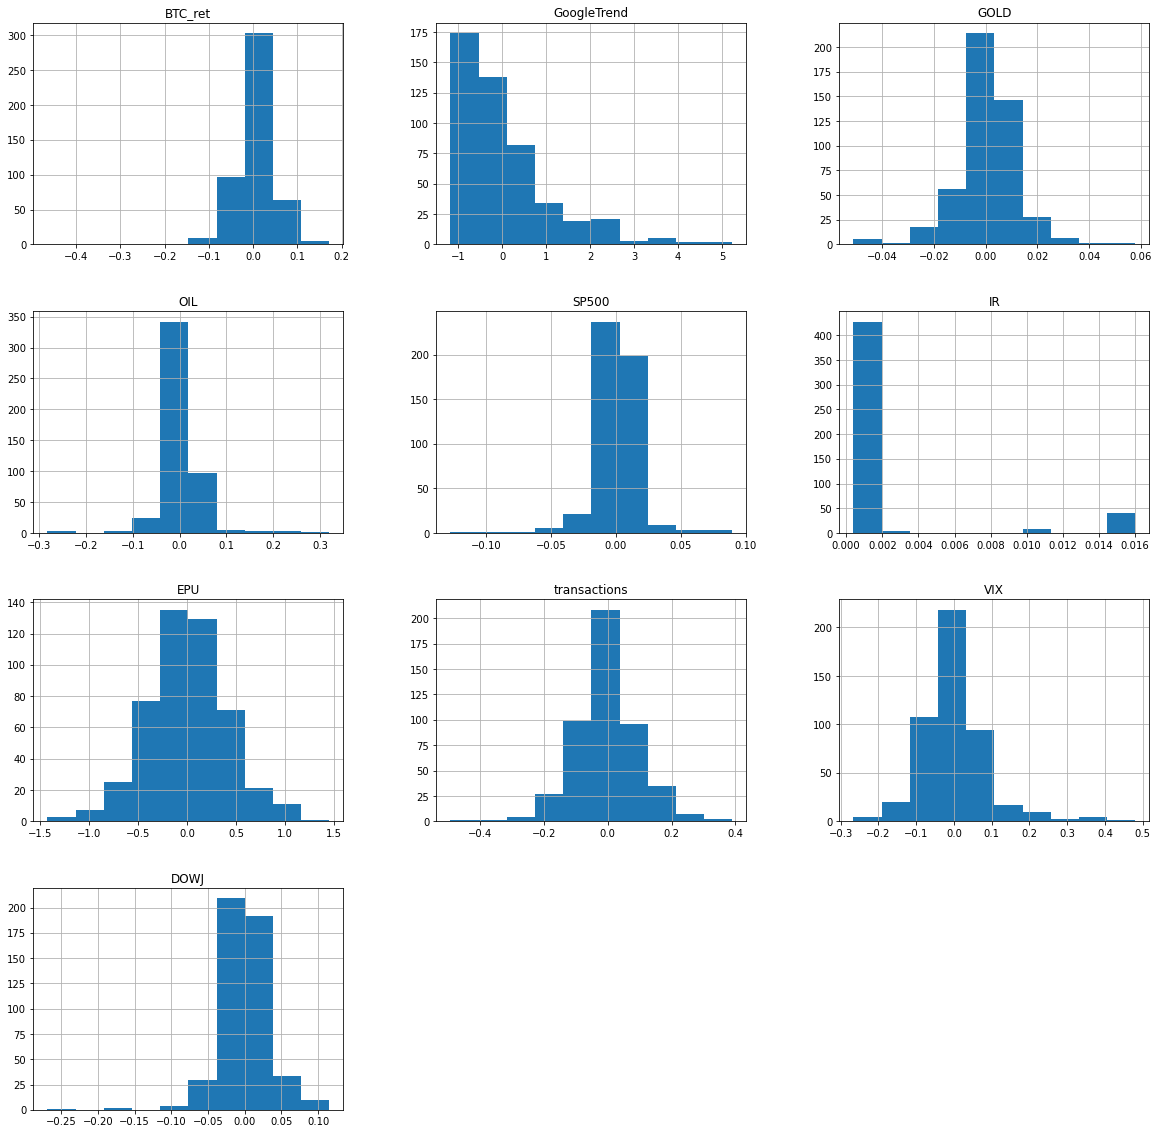

In [38]:
data_btc.hist(figsize=(20,20))

In [39]:
data_btc.describe()

,BTC_ret,GoogleTrend,GOLD,OIL,SP500,IR,EPU,transactions,VIX,DOWJ
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.003848,0.023512,0.000363,0.002016,0.000894,0.002227,0.002206,-0.000595,-0.000339,-0.000280
std,0.046000,1.044415,0.011858,0.044742,0.016691,0.004270,0.408618,0.096987,0.087595,0.034447
min,-0.464730,-1.176707,-0.051069,-0.282206,-0.127652,0.000400,-1.426062,-0.492266,-0.266228,-0.268934
25%,-0.015790,-0.727627,-0.004419,-0.011881,-0.004417,0.000700,-0.256170,-0.056303,-0.047618,-0.017785
50%,0.002509,-0.333941,0.000983,0.002624,0.001676,0.000900,-0.001416,-0.001831,-0.010288,-0.000725
75%,0.025792,0.405952,0.006180,0.016815,0.008010,0.000900,0.242917,0.047081,0.037940,0.015675
max,0.171821,5.227785,0.057775,0.319634,0.089683,0.016000,1.448161,0.389788,0.480214,0.115166


### Should we standardized/winsorized ? When doing histograms i did not see any outliers maybe not necessary ?

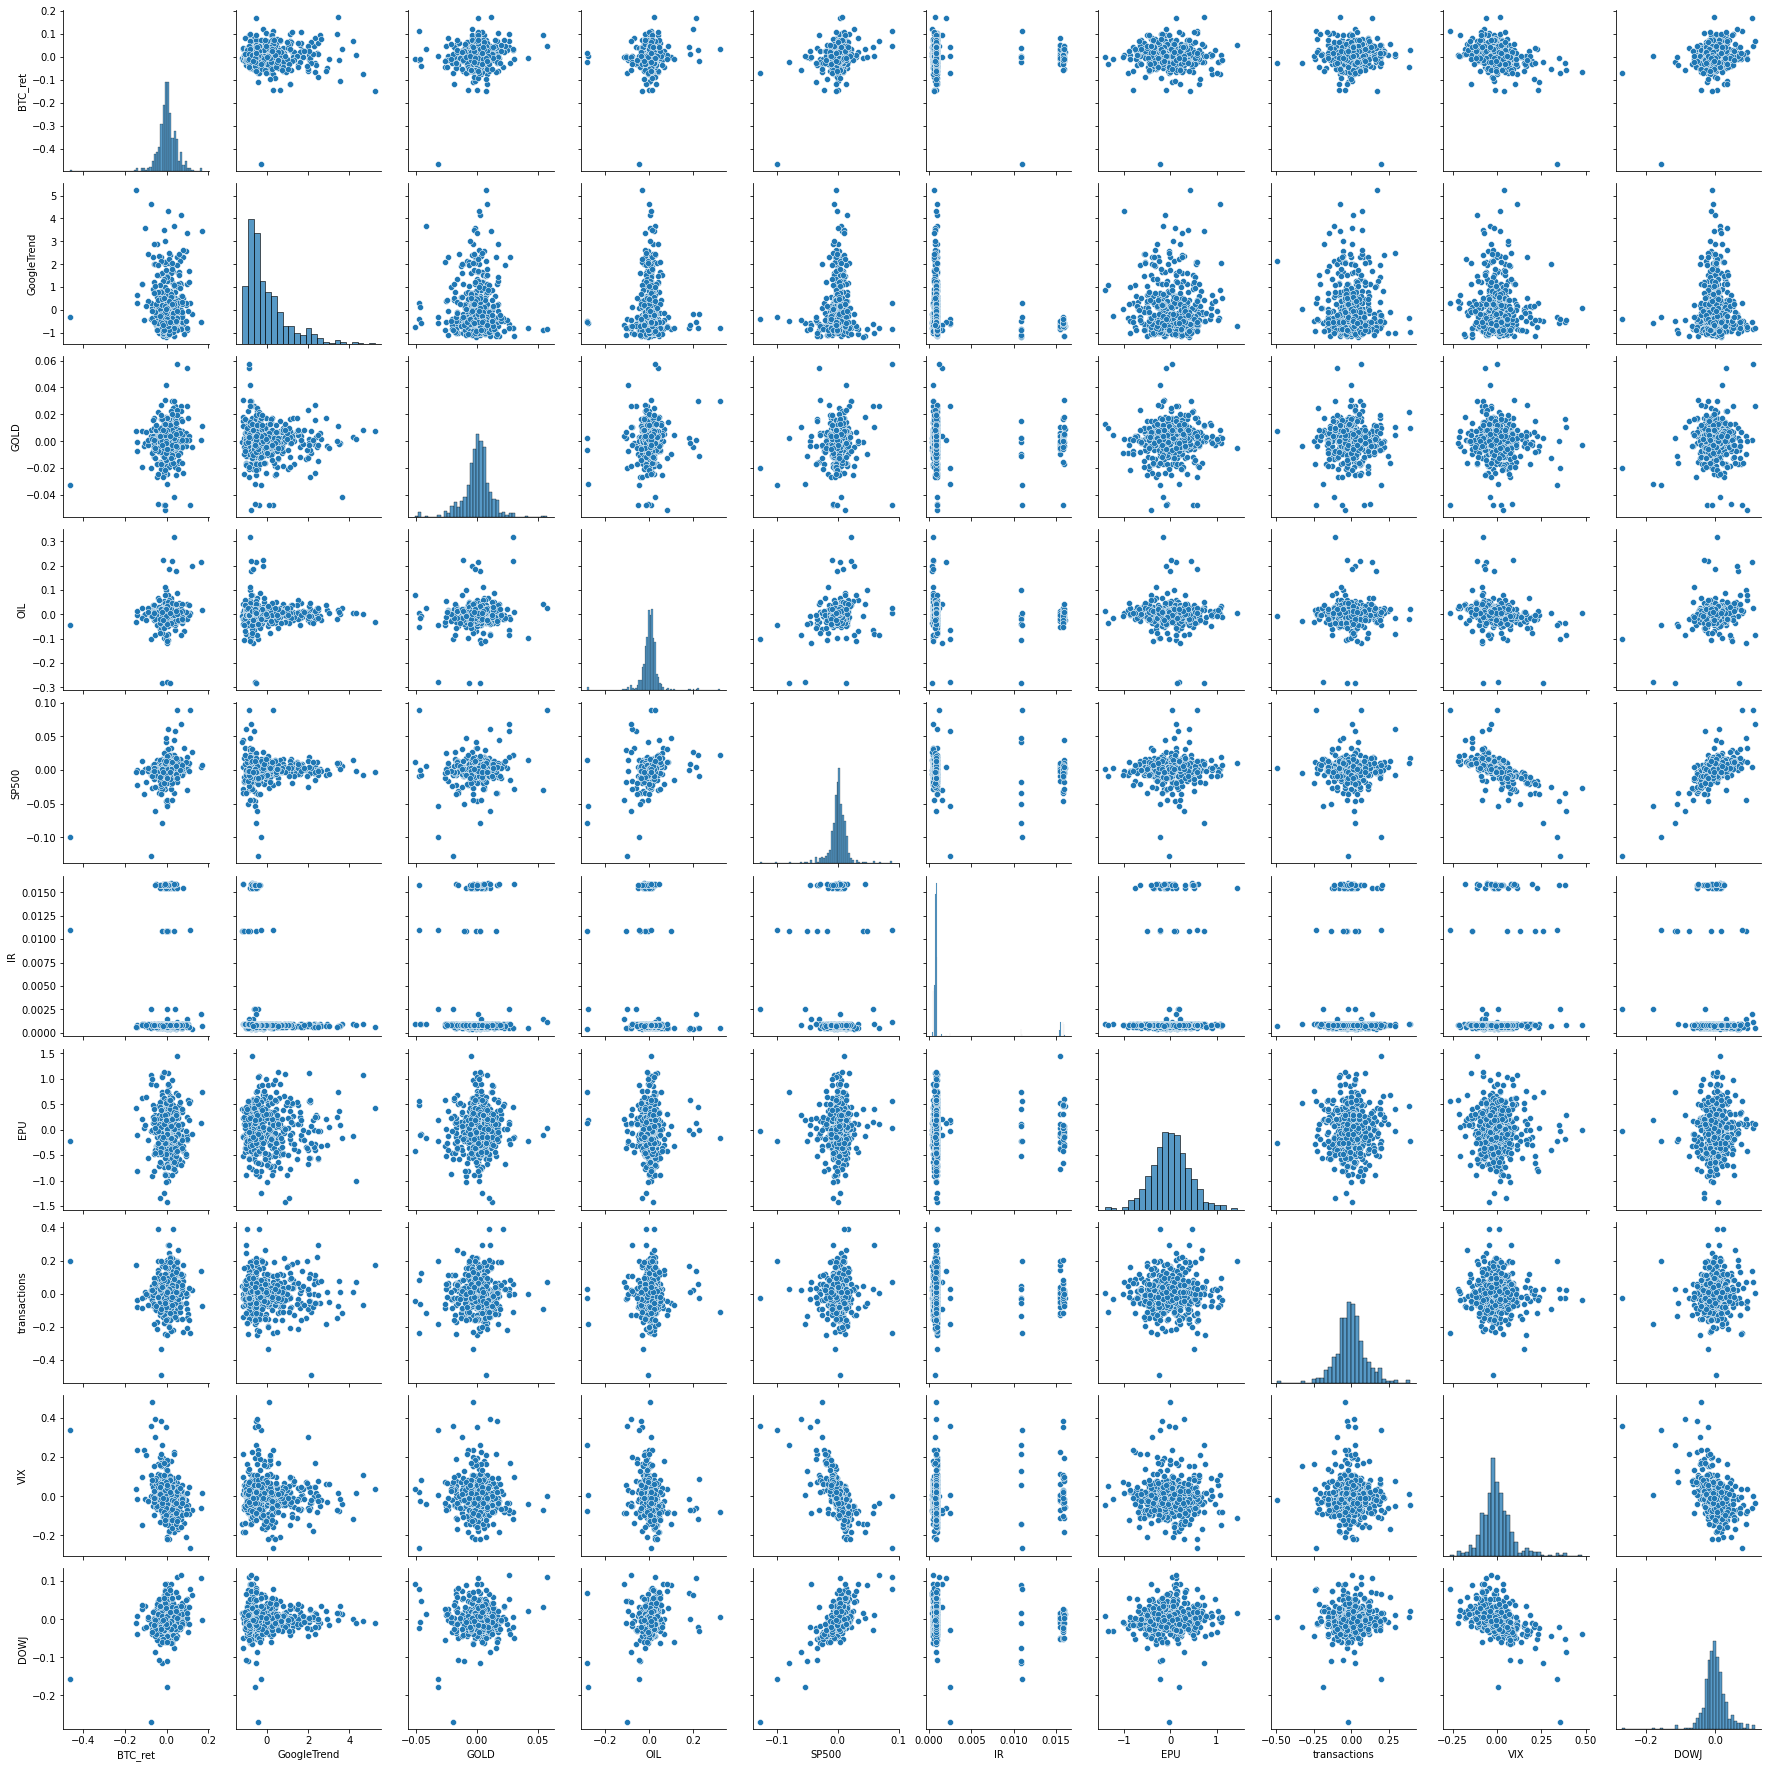

In [40]:
sns.pairplot(data_btc)

### Dickey-Fuller test (if needed)

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
https://www.statology.org/dickey-fuller-test-python/
https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/

In [41]:
#Def function for ADF, i found it on the internet :) --> same link as for the VAR
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [42]:
# ADF Test on each column
for name, column in data_btc.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "BTC_ret" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.1029
 No. Lags Chosen       = 1
 Critical value 1%     = -3.444
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GoogleTrend" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0751
 No. Lags Chosen       = 17
 Critical value 1%     = -3.445
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.2547. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "GOLD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

This thing probably looks much nicer than what i did, one variable after another. I let both options in here, but for the final output we can use just one :)

### Correlation matirx

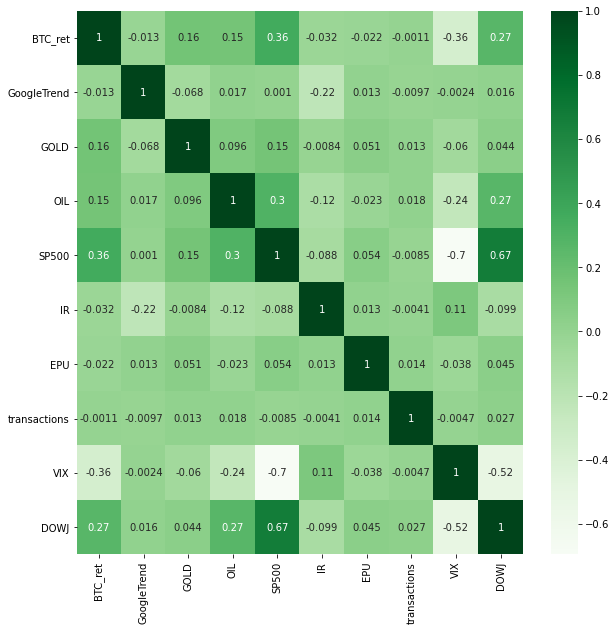

In [43]:
data_btc.corr()

# Plotting the seaborn heatmap 
fig = plt.figure(figsize=[10,10])
sns.heatmap(data_btc.corr(), annot=True, cmap="Greens")
plt.show()

In [44]:
data_btc.corr()

,BTC_ret,GoogleTrend,GOLD,OIL,SP500,IR,EPU,transactions,VIX,DOWJ
BTC_ret,1.000000,-0.013283,0.157241,0.148691,0.359746,-0.031891,-0.021650,-0.001140,-0.363022,0.271047
GoogleTrend,-0.013283,1.000000,-0.068098,0.017004,0.000995,-0.222772,0.012688,-0.009732,-0.002427,0.015989
GOLD,0.157241,-0.068098,1.000000,0.095975,0.148635,-0.008380,0.050982,0.013443,-0.059909,0.044107
OIL,0.148691,0.017004,0.095975,1.000000,0.299899,-0.116038,-0.022719,0.018095,-0.239211,0.270116
SP500,0.359746,0.000995,0.148635,0.299899,1.000000,-0.088371,0.053849,-0.008466,-0.695410,0.674946
IR,-0.031891,-0.222772,-0.008380,-0.116038,-0.088371,1.000000,0.013485,-0.004131,0.110085,-0.099500
EPU,-0.021650,0.012688,0.050982,-0.022719,0.053849,0.013485,1.000000,0.013679,-0.038020,0.044803
transactions,-0.001140,-0.009732,0.013443,0.018095,-0.008466,-0.004131,0.013679,1.000000,-0.004745,0.026925
VIX,-0.363022,-0.002427,-0.059909,-0.239211,-0.695410,0.110085,-0.038020,-0.004745,1.000000,-0.515919
DOWJ,0.271047,0.015989,0.044107,0.270116,0.674946,-0.099500,0.044803,0.026925,-0.515919,1.000000


### Classic OLS model
https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

In [45]:
x=data_btc.drop(columns=['BTC_ret'])

In [46]:
y=data_btc.BTC_ret

In [47]:
#Model without the constant - just the variables also considering IR but we can replace it later
results = sm.OLS(y, x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                BTC_ret   R-squared (uncentered):                   0.174
Model:                            OLS   Adj. R-squared (uncentered):              0.158
Method:                 Least Squares   F-statistic:                              11.03
Date:                Thu, 20 Jan 2022   Prob (F-statistic):                    1.14e-15
Time:                        17:50:57   Log-Likelihood:                          841.62
No. Observations:                 480   AIC:                                     -1665.
Df Residuals:                     471   BIC:                                     -1628.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
GoogleTrend      0.0002      0.002      0.093      0.926      -0.004       0.004
GOLD             0.4658      0.167      2.797      0.005       0.139       0.793
OIL              0.0320      0.046      0.700      0.484      -0.058       0.122
SP500            0.4346      0.191      2.270      0.024       0.058       0.811
IR               0.4518      0.412      1.096      0.274      -0.358       1.262
EPU             -0.0052      0.005     -1.096      0.274      -0.015       0.004
transactions    -0.0017      0.020     -0.086      0.932      -0.041       0.038
VIX             -0.1176      0.031     -3.800      0.000      -0.178      -0.057
DOWJ             0.0551      0.077      0.715      0.475      -0.096       0.206
==============================================================================
Omnibus:                      196.555   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3257.701
Skew:                          -1.320   Prob(JB):                         0.00
Kurtosis:                      15.487   Cond. No.                         223.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
model = ols("BTC_ret ~ OIL + GOLD + SP500 + GoogleTrend", data_btc)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                BTC_ret   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     19.63
Date:                Thu, 20 Jan 2022   Prob (F-statistic):           5.76e-15
Time:                        17:50:58   Log-Likelihood:                 834.10
No. Observations:                 480   AIC:                            -1658.
Df Residuals:                     475   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0028      0.002      1.434      

## VAR model
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
https://analyticsindiamag.com/hands-on-tutorial-on-vector-autoregressionvar-for-time-series-modeling/

<AxesSubplot:>

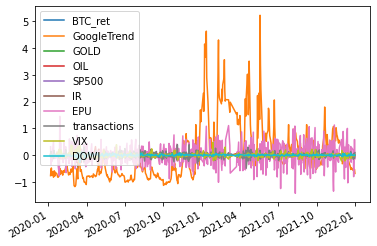

In [49]:
data_btc.plot()

### Granger's causality test - should we do that also ? 
By using granger’s causality test, we can find the relationship between the variables before building the model because it is known that if there is no relationship between the variables, we can drop the variables and separately do the modeling. If there is a relationship between them, we need to consider the variable in the modeling part.

In mathematics, the test provides the p-value between the variables, and if the p-value is higher than 0.05 then we will be required to accept the null hypothesis, and if the p-value is lesser than 0.05 we are required to reject the null hypothesis.

Statsmodel also provides a module to perform the test, so using the statsmodel next, I am performing the granger’s causality test.

In [50]:
from statsmodels.tsa.stattools import grangercausalitytests

### Cointegration test-  should we do that also ? 

Cointegration helps to find out the statistical connection between two or more time series. When two or more time series are cointegrated, they have a long run, statistically significant relationship.

In [51]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

### VAR

In [52]:
var = VAR(data_btc)

/Users/carlarunden/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [53]:
x= var.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,-60.24,-60.15,6.869e-27,-60.21
1,-66.37,-65.39*,1.499e-29,-65.98*
2,-66.60,-64.72,1.187e-29,-65.86
3,-66.94,-64.16,8.497e-30,-65.85
4,-67.03,-63.36,7.803e-30,-65.58
5,-67.06,-62.49,7.610e-30,-65.26
6,-67.08,-61.62,7.462e-30,-64.93
7,-67.14,-60.78,7.112e-30,-64.64
8,-67.10,-59.85,7.495e-30,-64.25
9,-67.23*,-59.09,6.672e-30*,-64.02


In [54]:
results = var.fit(9)
#We can check the summary of the model by.
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jan, 2022
Time:                     17:50:58
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -59.3019
Nobs:                     471.000    HQIC:                  -64.1714
Log likelihood:           10082.9    FPE:                6.03397e-30
AIC:                     -67.3293    Det(Omega_mle):     1.03145e-30
--------------------------------------------------------------------
Results for equation BTC_ret
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.006378         0.002760            2.311           0.021
L1.BTC_ret              0.008595         0.055700            0.154           0.877
L1.GoogleTrend          0.004412         0.004340 

In [55]:
results = var.fit(1)
#We can check the summary of the model by.
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jan, 2022
Time:                     17:50:58
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -65.5821
Nobs:                     479.000    HQIC:                  -66.1635
Log likelihood:           9249.63    FPE:                1.26488e-29
AIC:                     -66.5401    Det(Omega_mle):     1.00796e-29
--------------------------------------------------------------------
Results for equation BTC_ret
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.005411         0.002415            2.240           0.025
L1.BTC_ret             -0.088553         0.050252           -1.762           0.078
L1.GoogleTrend         -0.000118         0.002073 

#### If needed also ARDL